In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import torch
import gpytorch
import botorch

from botorch.models import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.mlls import ExactMarginalLogLikelihood, SumMarginalLogLikelihood
from botorch import fit_gpytorch_mll

import sklearn
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import shap

plt.rcParams['font.family'] = 'arial'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tkwargs = {
    "device": device,
    "dtype": torch.double,
}

import warnings

print(f"numpy {np.__version__}")
print(f"scikit-learn {sklearn.__version__}")
print(f"pytorch {torch.__version__}")
print(f"gpytorch {gpytorch.__version__}")
print(f"botorch {botorch.__version__}")

df = pd.read_csv("codope_data camp2.csv") 
df

numpy 2.2.6
scikit-learn 1.7.0
pytorch 2.6.0+cu118
gpytorch 1.14
botorch 0.15.1


,DGPAM ligands amount (mg),Reaction temperature(C),Reaction time(s),Cs/Pb,Yb/Pb,Er/Pb,Yb PLQY(%),Er PLQY(%),Batch
0,26.8,240,27,1.3,2.4,1.8,70,22,0
1,23.9,252,2,1.0,3.1,1.9,38,13,0
2,21.6,227,24,0.8,2.1,2.3,55,22,0
3,13.7,235,16,1.1,2.6,3.7,75,18,0
4,9.5,266,6,1.0,2.1,2.9,16,1,0
5,7.4,243,6,0.7,1.7,2.3,57,26,0
6,11.6,221,19,0.8,3.5,1.6,77,11,0
7,19.2,229,9,1.2,3.9,2.7,62,22,0
8,28.0,249,22,0.9,2.9,3.6,45,40,0
9,6.9,256,15,1.2,3.8,3.1,2,0,0


In [2]:
df.columns

Index(['DGPAM ligands amount (mg)', 'Reaction temperature(C)',
       'Reaction time(s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb', 'Yb PLQY(%)',
       'Er PLQY(%)', 'Batch'],
      dtype='object')

In [3]:
df[df['Batch']==0]

,DGPAM ligands amount (mg),Reaction temperature(C),Reaction time(s),Cs/Pb,Yb/Pb,Er/Pb,Yb PLQY(%),Er PLQY(%),Batch
0,24.1,260,30,0.8,2.7,3.6,67,32,0
1,30.0,262,30,0.8,3.5,3.6,56,29,0
2,14.6,258,30,0.8,2.6,3.6,67,27,0
3,30.0,262,29,0.6,2.4,3.6,67,32,0
4,29.2,261,30,1.0,2.4,3.6,64,29,0
5,30.0,262,30,1.2,2.3,3.6,67,25,0
6,26.8,240,27,1.3,2.4,1.8,75,20,0
7,23.9,252,2,1.0,3.1,1.9,61,21,0
8,21.6,227,24,0.8,2.1,2.3,86,28,0
9,13.7,235,16,1.1,2.6,3.7,61,26,0


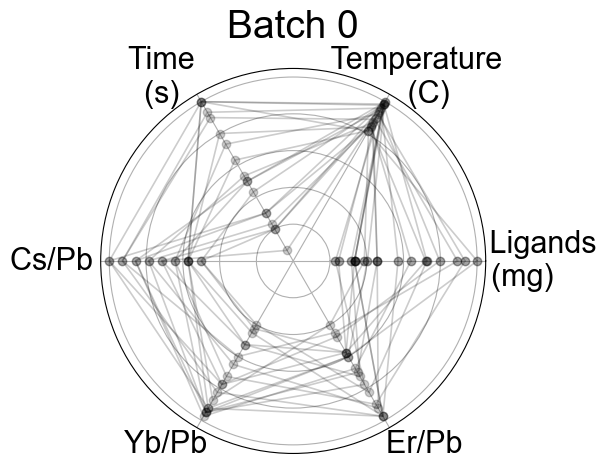

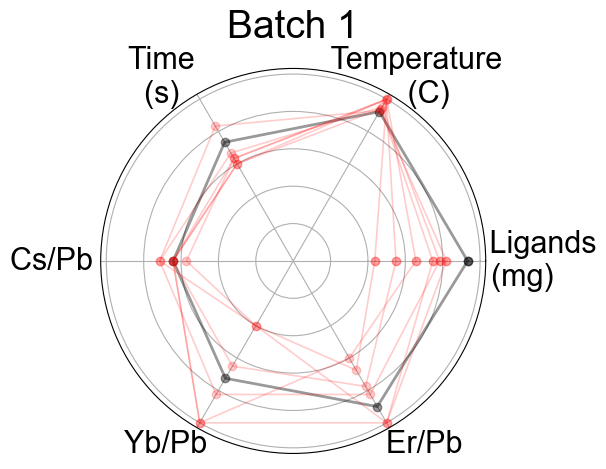

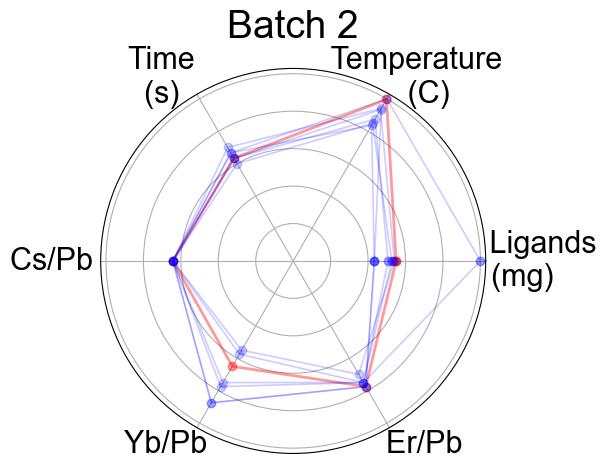

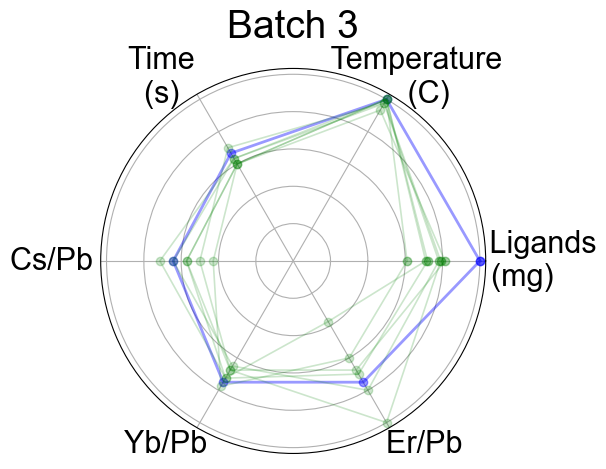

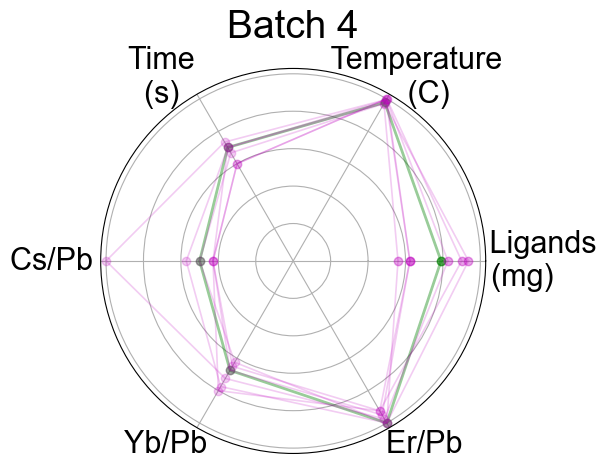

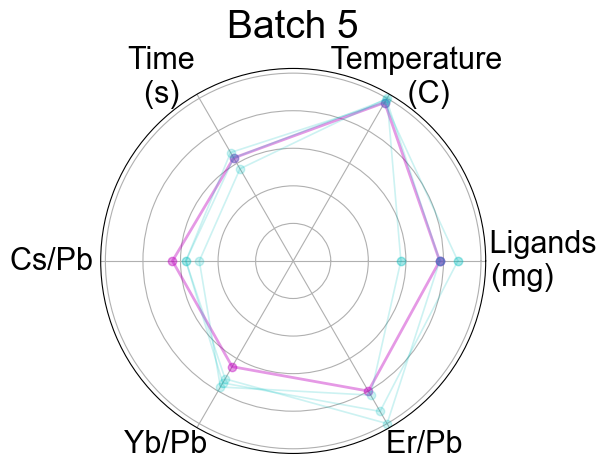

In [54]:
labels = ['DGPAM ligands amount (mg)', 'Reaction temperature(C)',
       'Reaction time(s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb', ]

batch_all = df[labels].to_numpy()
batch_all = batch_all / batch_all.max(axis=0)
batch0 = batch_all[df['Batch']==0]
batch1 = batch_all[df['Batch']==1]
batch2 = batch_all[df['Batch']==2]
batch3 = batch_all[df['Batch']==3]
batch4 = batch_all[df['Batch']==4]
batch5 = batch_all[df['Batch']==5]

best0 = batch0[df.loc[df['Batch']==0, 'Er PLQY(%)',].argmax().item()]
best_values0 = best0.tolist()
best_values0 += best_values0[:1]  # Close the line

best1 = batch1[df.loc[df['Batch']==1, 'Er PLQY(%)',].argmax().item()]
best_values1 = best1.tolist()
best_values1 += best_values1[:1]  # Close the line

best2 = batch2[df.loc[df['Batch']==2, 'Er PLQY(%)',].argmax().item()]
best_values2 = best2.tolist()
best_values2 += best_values2[:1]  # Close the line

best3 = batch3[df.loc[df['Batch']==3, 'Er PLQY(%)',].argmax().item()]
best_values3 = best3.tolist()
best_values3 += best_values3[:1]  # Close the line

best4 = batch3[df.loc[df['Batch']==4, 'Er PLQY(%)',].argmax().item()]
best_values4 = best4.tolist()
best_values4 += best_values4[:1]  # Close the line

num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

labels = ['         Ligands\n    (mg)', '    Temperature\n       (C)',
       'Time      \n(s)      ', 'Cs/Pb       ', 'Yb/Pb     ', '      Er/Pb', ]

for batch, c, number in zip([batch0, batch1, batch2, batch3, batch4, batch5],
                    ['k', 'r', 'b', 'g', 'm', 'c'], [0, 1, 2, 3, 4, 5]):

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})

    
    if number == 1:
        ax.plot(angles, best_values0, 'o-', linewidth=2, c='k', alpha=0.4)   
    elif number == 2:
        ax.plot(angles, best_values1, 'o-', linewidth=2, c='r', alpha=0.4)   
    elif number == 3:
        ax.plot(angles, best_values2, 'o-', linewidth=2, c='b', alpha=0.4)
    elif number == 4:
        ax.plot(angles, best_values3, 'o-', linewidth=2, c='g', alpha=0.4) 
    elif number == 5:
        ax.plot(angles, best_values4, 'o-', linewidth=2, c='m', alpha=0.4) 
    
    for i, sample in enumerate(batch):
        values = sample.tolist()
        values += values[:1]  # Close the line
        ax.plot(angles, values, 'o-', linewidth=1.2, c=c, alpha=0.2)
        #ax.fill(angles, values, alpha=0.01, c=c)  # Optional fill
 
    
    
    # Set axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=22,)
    ax.set_yticklabels([])  # Remove radial labels
    
    # Add legend and title
    #plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.title(f'Batch {number}', fontsize=28)
    plt.show()

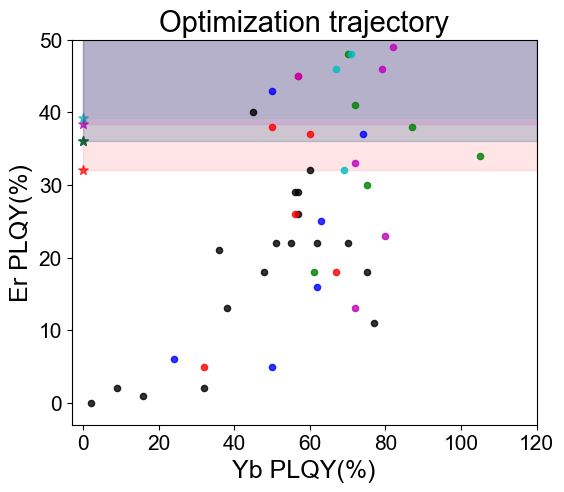

In [26]:
import matplotlib.patches as patches


fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.scatter(0, df[df['Batch']==0]['Er PLQY(%)'].max()*0.8, #label='Batch1 (ref)', 
           marker='*', c='r', alpha=0.7, s=50)
ax.scatter(0, df[df['Batch']<=1]['Er PLQY(%)'].max()*0.8, #label='Batch2 (ref)',
           marker='*', c='b', alpha=0.7, s=50)
ax.scatter(0, df[df['Batch']<=2]['Er PLQY(%)'].max()*0.8, #label='Batch3 (ref)',
           marker='*', c='g', alpha=0.7, s=50)
ax.scatter(0, df[df['Batch']<=3]['Er PLQY(%)'].max()*0.8, #label='Batch3 (ref)',
           marker='*', c='m', alpha=0.7, s=50)
ax.scatter(0, df[df['Batch']<=4]['Er PLQY(%)'].max()*0.8, #label='Batch3 (ref)',
           marker='*', c='c', alpha=0.7, s=50)


rect = patches.Rectangle((0, df[df['Batch']==0]['Er PLQY(%)'].max()*0.8), 120, 80, linewidth=1, edgecolor='r', facecolor='r', alpha=0.1)
ax.add_patch(rect)
rect = patches.Rectangle((0, df[df['Batch']<=1]['Er PLQY(%)'].max()*0.8), 120, 80, linewidth=1, edgecolor='b', facecolor='b', alpha=0.1)
ax.add_patch(rect)
rect = patches.Rectangle((0, df[df['Batch']<=2]['Er PLQY(%)'].max()*0.8), 120, 80, linewidth=1, edgecolor='g', facecolor='g', alpha=0.1)
ax.add_patch(rect)
rect = patches.Rectangle((0, df[df['Batch']<=3]['Er PLQY(%)'].max()*0.8), 120, 80, linewidth=1, edgecolor='m', facecolor='m', alpha=0.1)
ax.add_patch(rect)
rect = patches.Rectangle((0, df[df['Batch']<=4]['Er PLQY(%)'].max()*0.8), 120, 80, linewidth=1, edgecolor='c', facecolor='c', alpha=0.1)
ax.add_patch(rect)


for batch, batch_col in zip(
    [0, 1, 2, 3, 4, 5], ['k', 'r', 'b', 'g', 'm', 'c']):

    df_batch = df[df['Batch']==batch]
    
    ax.scatter(
        df_batch['Yb PLQY(%)'], df_batch['Er PLQY(%)'],
        label=f"Batch {batch}", c=batch_col, alpha=0.8, s=20)

ax.set_xlim(-3, 120.0)
ax.set_ylim(-3, 50.0)

ax.set_xlabel('Yb PLQY(%)', fontsize=18)
ax.set_ylabel('Er PLQY(%)', fontsize=18)
#ax.legend(loc='upper right', fontsize=12)
1
ax.set_title("Optimization trajectory", fontsize=21)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

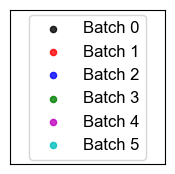

In [28]:
figsize = (2, 2)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', fontsize=12)
ax_leg.set_xticks([])
ax_leg.set_yticks([])
fig_leg.set_frameon(False)

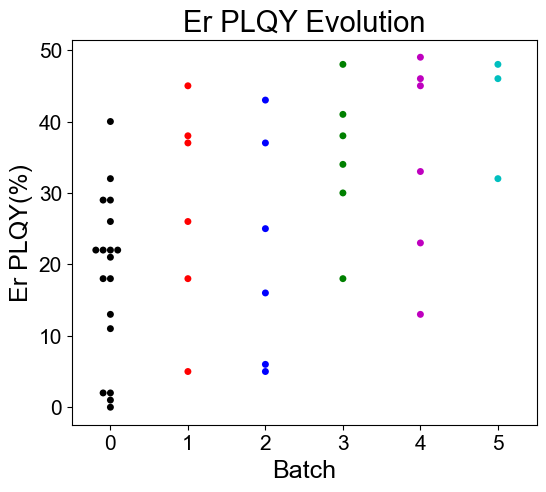

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sb.swarmplot(df,
             x='Batch',
             y='Er PLQY(%)',
             hue='Batch',
             palette=['k', 'r', 'b', 'g', 'm', 'c'],
             ax=ax, legend=False,
            )

#ax.axhline(y=10, color='r', linestyle='--')
#ax.axhline(y=30, color='b', linestyle='--')
#ax.axhline(y=35, color='g', linestyle='--')

ax.set_xlabel('Batch', fontsize=18)
ax.set_ylabel('Er PLQY(%)', fontsize=18)

ax.set_title("Er PLQY Evolution", fontsize=21)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

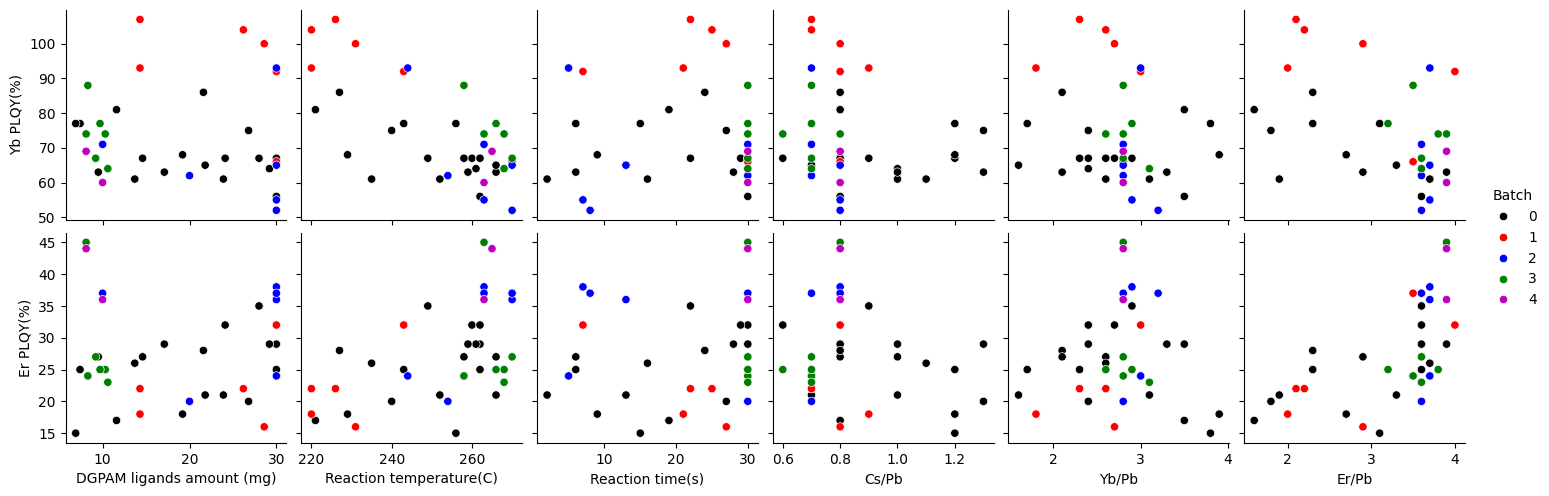

In [16]:
sb.pairplot(df, 
            x_vars=['DGPAM ligands amount (mg)', 'Reaction temperature(C)','Reaction time(s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb'],
            y_vars=['Yb PLQY(%)', 'Er PLQY(%)'], 
            hue='Batch', palette=['k', 'r', 'b', 'g', 'm'],
           )

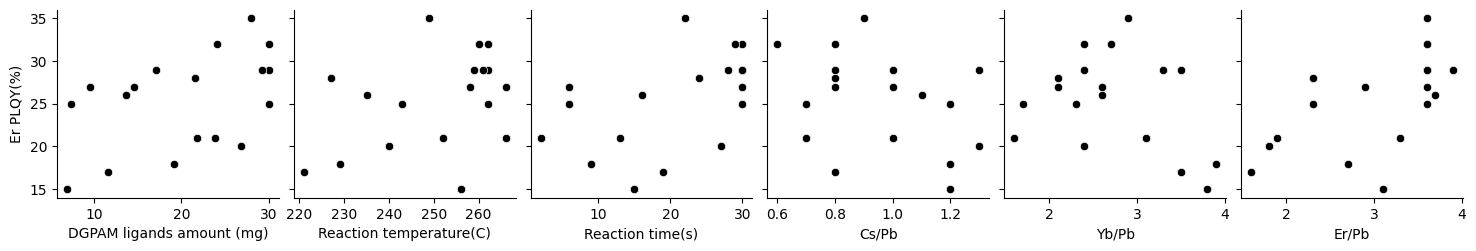

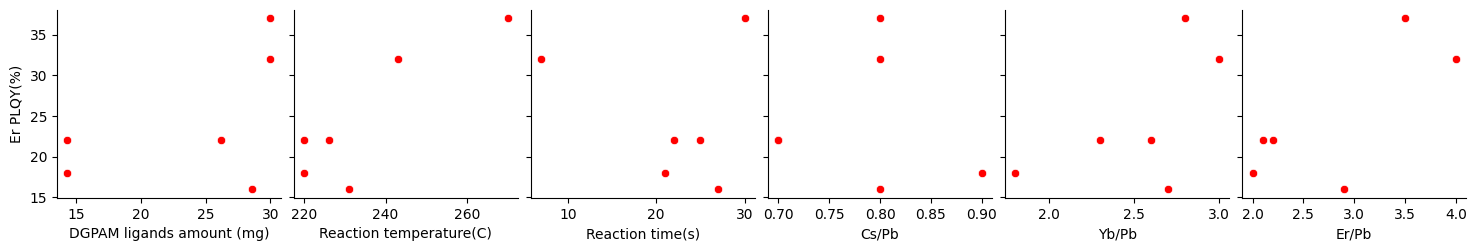

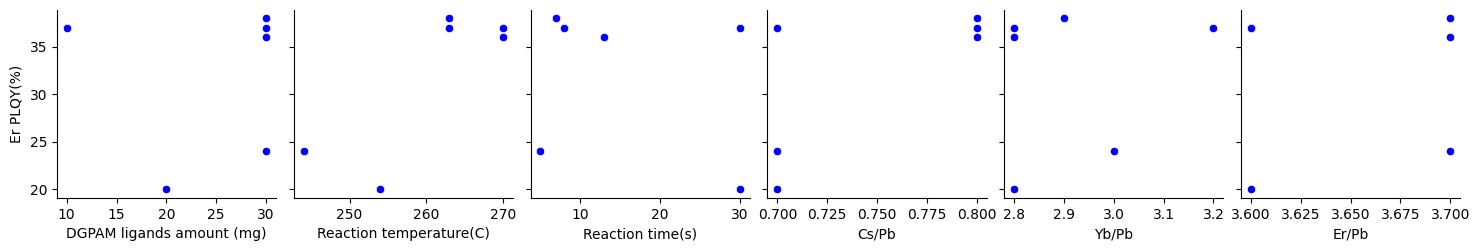

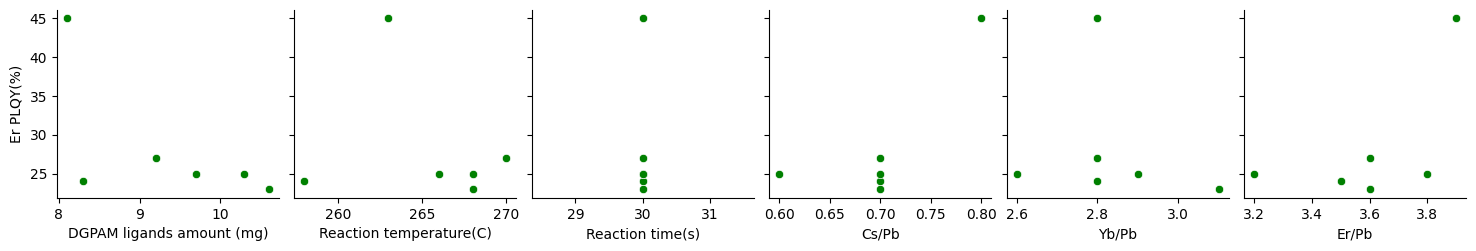

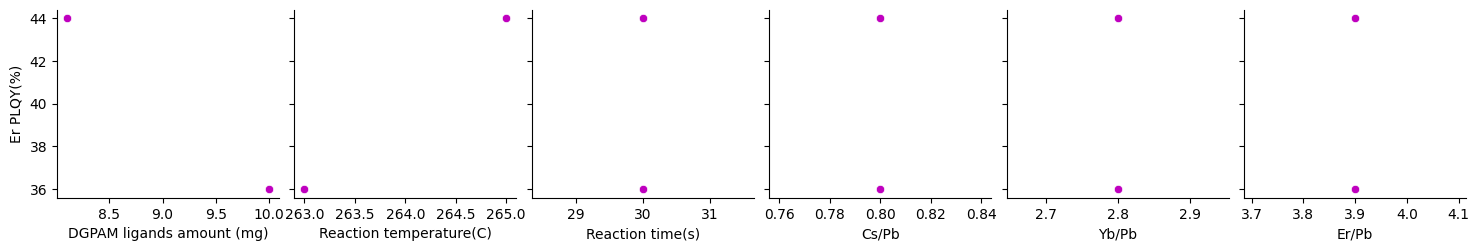

In [31]:
for batch, color in enumerate(['k', 'r', 'b', 'g', 'm']):
    sb.pairplot(df[df['Batch']==batch], 
            x_vars=['DGPAM ligands amount (mg)', 'Reaction temperature(C)','Reaction time(s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb'],
            y_vars=['Er PLQY(%)'], 
            plot_kws={'color': color, } ,
           )

In [30]:
####################
# initialization

n_var = 6
n_obj = 2

random_state = 42
torch.manual_seed(random_state) # gives a consistent seed based on the trial number

lower_bounds = torch.tensor([5.0, 220.0, 1.0, 0.6, 1.5, 1.5], **tkwargs) 
upper_bounds = torch.tensor([30.0, 270.0, 30.0, 1.4, 4, 4.0], **tkwargs)
problem_bounds = torch.vstack([lower_bounds, upper_bounds])

standard_bounds = torch.zeros(2, n_var, **tkwargs)
standard_bounds[1] = 1

train_x = df[['DGPAM ligands amount (mg)', 'Reaction temperature(C)', 'Reaction time(s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb', ]].to_numpy()
train_x = torch.tensor(train_x, **tkwargs)
train_x_gp = normalize(train_x, problem_bounds)

train_y = df[['Yb PLQY(%)', 'Er PLQY(%)']].to_numpy()
train_y = torch.tensor(train_y, **tkwargs)

In [31]:
models = []
for i in range(train_y.shape[-1]):
    models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
model = ModelListGP(*models)
mll = SumMarginalLogLikelihood(model.likelihood, model)

fit_gpytorch_mll(mll);

In [33]:
with torch.no_grad():

    posterior = model.posterior(train_x_gp)
    means = posterior.mean.cpu().numpy()
    variances = posterior.variance.cpu().numpy()

df['Pred Yb PLQY(%)'] = means[:,0]
df['Pred Er PLQY(%)'] = means[:,1]
df['Var Yb PLQY(%)'] = variances[:,0]
df['Var Er PLQY(%)'] = variances[:,1]
df['CI Yb PLQY(%)'] = 1.96 * np.sqrt(df['Var Yb PLQY(%)'])
df['CI Er PLQY(%)'] = 1.96 * np.sqrt(df['Var Er PLQY(%)'])

df

,DGPAM ligands amount (mg),Reaction temperature(C),Reaction time(s),Cs/Pb,Yb/Pb,Er/Pb,Yb PLQY(%),Er PLQY(%),Batch,Pred Yb PLQY(%),Pred Er PLQY(%),Var Yb PLQY(%),Var Er PLQY(%),CI Yb PLQY(%),CI Er PLQY(%)
0,26.8,240,27,1.3,2.4,1.8,70,22,0,69.870981,21.991648,3.063660,1.125214,3.430649,2.079092
1,23.9,252,2,1.0,3.1,1.9,38,13,0,38.106421,13.043962,3.063661,1.125261,3.430650,2.079135
2,21.6,227,24,0.8,2.1,2.3,55,22,0,54.969973,21.964795,3.063515,1.123968,3.430568,2.077941
3,13.7,235,16,1.1,2.6,3.7,75,18,0,74.799798,17.974031,3.058198,1.124316,3.427590,2.078262
4,9.5,266,6,1.0,2.1,2.9,16,1,0,16.229811,1.141566,3.063250,1.125208,3.430420,2.079086
5,7.4,243,6,0.7,1.7,2.3,57,26,0,56.966647,25.969588,3.063660,1.125459,3.430650,2.079318
6,11.6,221,19,0.8,3.5,1.6,77,11,0,76.847721,11.122513,3.062071,1.112954,3.429760,2.067734
7,19.2,229,9,1.2,3.9,2.7,62,22,0,61.870900,21.825335,3.061310,1.117708,3.429333,2.072146
8,28.0,249,22,0.9,2.9,3.6,45,40,0,45.042430,39.923434,3.059453,1.115456,3.428293,2.070057
9,6.9,256,15,1.2,3.8,3.1,2,0,0,2.370194,0.136974,3.063611,1.122948,3.430622,2.076997


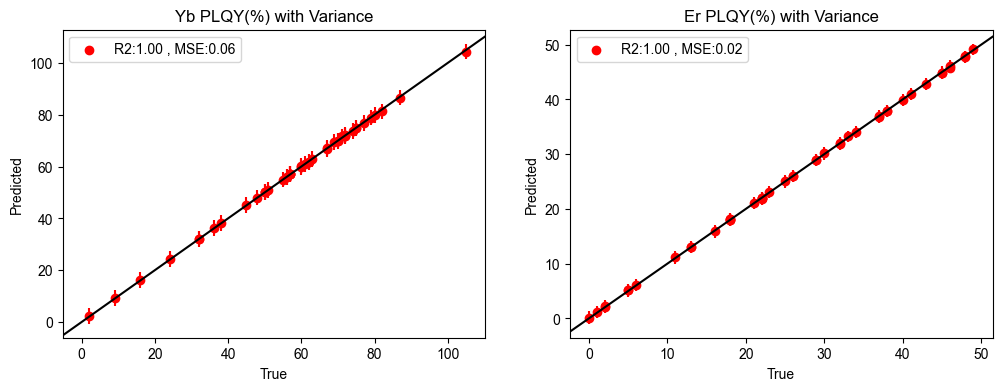

In [34]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, objective in enumerate(['Yb PLQY(%)', 'Er PLQY(%)']):
    ax = axes[i]
    
    r2 = r2_score(
        df[f'{objective}'], df[f'Pred {objective}'])
    mse = mean_squared_error(
        df[f'{objective}'], df[f'Pred {objective}'])

    ax.errorbar(
        df[f'{objective}'], df[f'Pred {objective}'], 
        yerr=df[f'Var {objective}'], 
        linestyle='none', fmt='', color='r')
    ax.scatter(
        df[f'{objective}'], df[f'Pred {objective}'],
        color='r',
        label=f'R2:{r2:.2f} , MSE:{mse:.2f}'
    )
    
    ax.axline((0, 0), slope=1, color='k', linestyle='-')
    ax.set_title(f'{objective} with Variance')
    ax.set(xlabel=f'True', ylabel=f'Predicted')
    ax.legend()

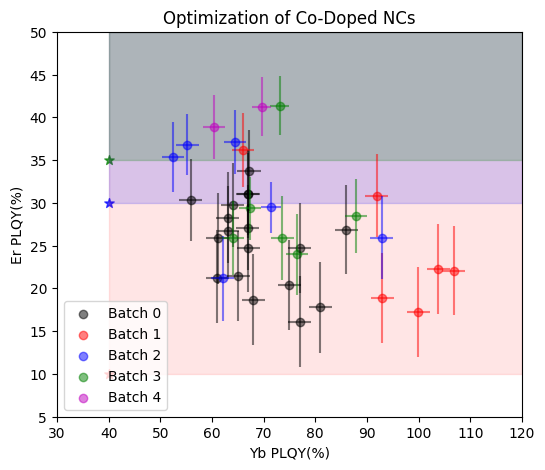

In [7]:
import matplotlib.patches as patches


fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.scatter(40, 10, #label='Batch1 (ref)', 
           marker='*', c='r', alpha=0.7, s=50)
ax.scatter(40, 30, #label='Batch2 (ref)',
           marker='*', c='b', alpha=0.7, s=50)
ax.scatter(40, 35, #label='Batch3 (ref)',
           marker='*', c='g', alpha=0.7, s=50)


rect = patches.Rectangle((40, 10), 80, 40, linewidth=1, edgecolor='r', facecolor='r', alpha=0.1)
ax.add_patch(rect)
rect = patches.Rectangle((40, 30), 80, 20, linewidth=1, edgecolor='b', facecolor='b', alpha=0.15)
ax.add_patch(rect)
rect = patches.Rectangle((40, 35), 80, 15, linewidth=1, edgecolor='g', facecolor='g', alpha=0.2)
ax.add_patch(rect)


for batch, batch_col in zip(
    [0, 1, 2, 3, 4], ['k', 'r', 'b', 'g', 'm']):

    df_batch = df[df['Batch']==batch]
    
    ax.errorbar(
        df_batch['Pred Yb PLQY(%)'], df_batch['Pred Er PLQY(%)'], 
        xerr = df_batch['CI Yb PLQY(%)'], yerr = df_batch['CI Er PLQY(%)'],
        linestyle='none', fmt='', c=batch_col, alpha=0.5)
    
    ax.scatter(
        df_batch['Pred Yb PLQY(%)'], df_batch['Pred Er PLQY(%)'],
        label=f"Batch {batch}", c=batch_col, alpha=0.5)

ax.set_xlim(30, 120.0)
ax.set_ylim(5, 50.0)

ax.set_xlabel('Yb PLQY(%)')
ax.set_ylabel('Er PLQY(%)')
ax.set_title('Optimization of Co-Doped NCs')
ax.legend()

C:\Users\lowka\anaconda3\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


  0%|          | 0/45 [00:00<?, ?it/s]

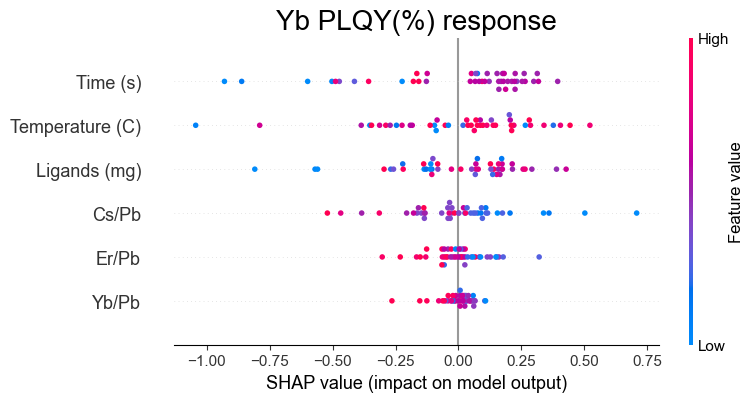

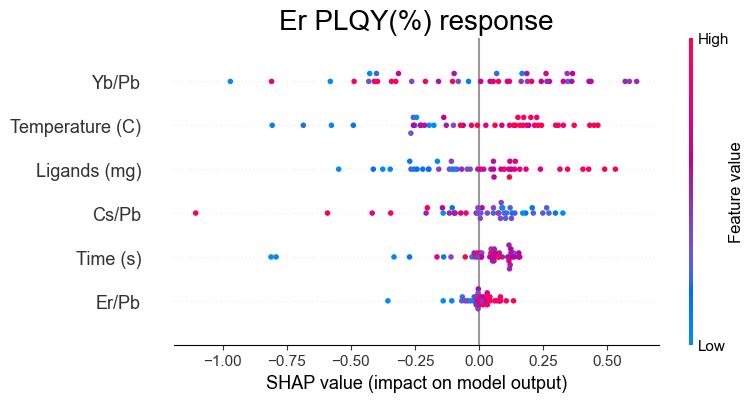

In [38]:
plt.rcParams['axes.labelsize'] = 18

def st_predict(x: np.ndarray):
    x_tensor = torch.tensor(x, **tkwargs)
    model.eval()
    with torch.no_grad():
        predictions = torch.hstack([
            model.models[0](x_tensor).mean.unsqueeze(1),
            model.models[1](x_tensor).mean.unsqueeze(1),
        ]).cpu().numpy()

    return predictions

explainer = shap.KernelExplainer(st_predict, train_x_gp.cpu().numpy())
shap_values = explainer.shap_values(train_x_gp.cpu().numpy())

for i, objective in enumerate(['Yb PLQY(%)', 'Er PLQY(%)']):

    shap.summary_plot(
        shap_values[:,:,i], train_x_gp.cpu().numpy(), 
        feature_names=['Ligands (mg)', 'Temperature (C)', 'Time (s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb'],
        show=False,
                     )

    plt.title(f"{objective} response", fontsize=20)
    plt.show()

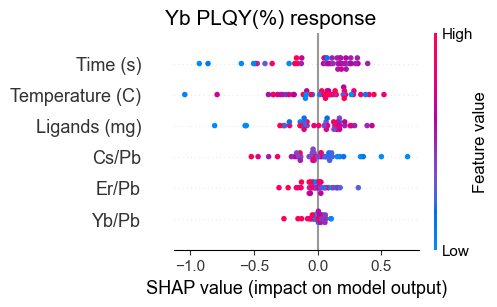

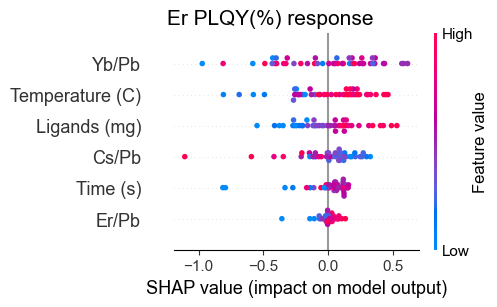

In [39]:
for i, objective in enumerate(['Yb PLQY(%)', 'Er PLQY(%)']):

    shap.summary_plot(
        shap_values[:,:,i], train_x_gp.cpu().numpy(), 
        feature_names=['Ligands (mg)', 'Temperature (C)', 'Time (s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb'],
        show=False, plot_size=(5, 3), #color_bar=False,
                     )

    plt.title(f"{objective} response         ", fontsize=15)
    plt.show()

In [9]:
df.columns

Index(['DGPAM ligands amount (mg)', 'Reaction temperature(C)',
       'Reaction time(s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb', 'Yb PLQY(%)',
       'Er PLQY(%)', 'Batch', 'Pred Yb PLQY(%)', 'Pred Er PLQY(%)',
       'Var Yb PLQY(%)', 'Var Er PLQY(%)', 'CI Yb PLQY(%)', 'CI Er PLQY(%)'],
      dtype='object')

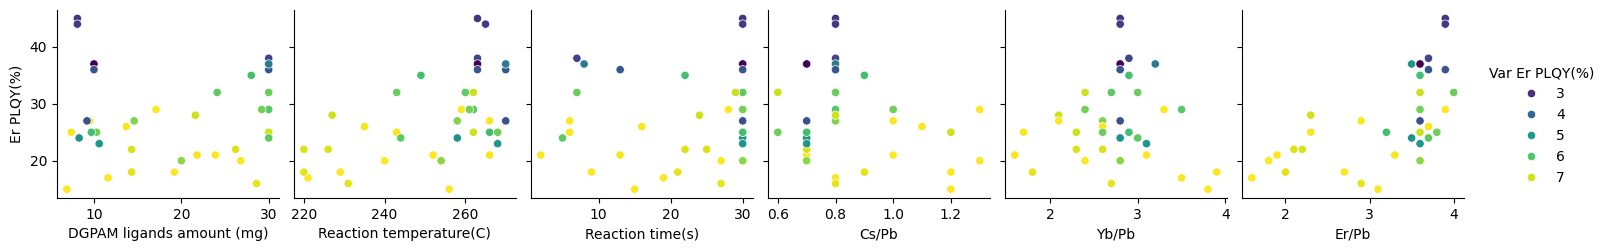

In [10]:
sb.pairplot(df, 
            x_vars=['DGPAM ligands amount (mg)', 'Reaction temperature(C)', 'Reaction time(s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb'],
            y_vars=['Er PLQY(%)'], 
            hue='Var Er PLQY(%)', palette='viridis'
           )